# Coupled Cluster Reference Data Processing

* Counterpoise correction
* Basis set extrapolation
* 50 PES points (0,0,z)

In [8]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error

from helplers.q_chem import *

DATA_DIR = f"../data/HeBz"

cc_res = np.load(f"{DATA_DIR}/CC_HeBz_50.npy", allow_pickle=True).item()

energy_unit = to_cm_1

In [9]:
cp_correction = True
explt_hf = True


distances = list(cc_res.keys())


sorted_distances = sorted(distances, key=lambda x: float(x))

results = {}

for distance in sorted_distances:

    results[distance] = {}
    basis_sets = cc_res[distance]

    for basis_set in basis_sets.keys():

        results[distance][basis_set] = {}

        hf_hebz = basis_sets[basis_set]["HeBz"]["rhf"]
        hf_he_gbz = basis_sets[basis_set]["He_gBz"]["rhf"]
        hf_bz_ghe = basis_sets[basis_set]["Bz_gHe"]["rhf"]

        hf_en = hf_hebz - hf_he_gbz - hf_bz_ghe if cp_correction else hf_hebz

        sd_hebz = basis_sets[basis_set]["HeBz"]["sd"]
        sd_he_gbz = basis_sets[basis_set]["He_gBz"]["sd"]
        sd_bz_ghe = basis_sets[basis_set]["Bz_gHe"]["sd"]

        sd_en = sd_hebz - sd_he_gbz - sd_bz_ghe if cp_correction else sd_hebz

        t_hebz = (
            basis_sets[basis_set]["HeBz"]["td"] + basis_sets[basis_set]["HeBz"]["ts"]
        )
        t_he_gbz = (
            basis_sets[basis_set]["He_gBz"]["td"]
            + basis_sets[basis_set]["He_gBz"]["ts"]
        )
        t_bz_ghe = (
            basis_sets[basis_set]["Bz_gHe"]["td"]
            + basis_sets[basis_set]["Bz_gHe"]["ts"]
        )

        t_en = t_hebz - t_he_gbz - t_bz_ghe if cp_correction else t_hebz

        results[distance][basis_set]["hf"] = hf_en
        results[distance][basis_set]["sd"] = sd_en
        results[distance][basis_set]["t"] = t_en

    hf_dz = results[distance]["aug-cc-pVDZ"]["hf"]
    hf_tz = results[distance]["aug-cc-pVTZ"]["hf"]
    hf_qz = results[distance]["aug-cc-pVQZ"]["hf"]

    hf_cbs_dt = helgaker_hf_cbs(hf_dz, hf_tz) if explt_hf else hf_tz
    hf_cbs_tq = helgaker_hf_cbs(hf_tz, hf_qz) if explt_hf else hf_qz

    cc_sd_cbs_dt = cc_helgaker_cbs_2pts(
        results[distance]["aug-cc-pVDZ"]["sd"],
        results[distance]["aug-cc-pVTZ"]["sd"],
        2,
        3,
    )

    cc_t_cbs_dt = cc_helgaker_cbs_2pts(
        results[distance]["aug-cc-pVDZ"]["t"],
        results[distance]["aug-cc-pVTZ"]["t"],
        2,
        3,
    )

    cc_sd_cbs_tq = cc_helgaker_cbs_2pts(
        results[distance]["aug-cc-pVTZ"]["sd"],
        results[distance]["aug-cc-pVQZ"]["sd"],
        3,
        4,
    )

    cc_t_cbs_tq = cc_helgaker_cbs_2pts(
        results[distance]["aug-cc-pVTZ"]["t"],
        results[distance]["aug-cc-pVQZ"]["t"],
        3,
        4,
    )

    results[distance]["cbs-dt"] = {
        "hf": hf_cbs_dt,
        "sd": cc_sd_cbs_dt,
        "t": cc_t_cbs_dt,
    }

    results[distance]["cbs-tq"] = {
        "hf": hf_cbs_tq,
        "sd": cc_sd_cbs_tq,
        "t": cc_t_cbs_tq,
    }


sorted_res = []

for distance in sorted_distances:
    sorted_res.append((distance, results[str(distance)]))


sorted_results = sorted_res


aug_cc_pVDZ = [
    [
        (
            result[1]["aug-cc-pVDZ"]["hf"]
            + result[1]["aug-cc-pVDZ"]["sd"]
            + result[1]["aug-cc-pVDZ"]["t"]
        )
        * energy_unit[0],
    ]
    for result in sorted_results
]


aug_cc_pVTZ = [
    [
        (
            result[1]["aug-cc-pVTZ"]["hf"]
            + result[1]["aug-cc-pVTZ"]["sd"]
            + result[1]["aug-cc-pVTZ"]["t"]
        )
        * energy_unit[0],
    ]
    for result in sorted_results
]


aug_cc_pVQZ = [
    [
        (
            result[1]["aug-cc-pVQZ"]["hf"]
            + result[1]["aug-cc-pVQZ"]["sd"]
            + result[1]["aug-cc-pVQZ"]["t"]
        )
        * energy_unit[0],
    ]
    for result in sorted_results
]


cbs_tq = [
    [
        (
            result[1]["cbs-tq"]["hf"]
            + result[1]["cbs-tq"]["sd"]
            + result[1]["cbs-tq"]["t"]
        )
        * energy_unit[0]
    ]
    for result in sorted_results
]

cbs_dt = [
    [
        (
            result[1]["cbs-dt"]["hf"]
            + result[1]["cbs-dt"]["sd"]
            + result[1]["cbs-dt"]["t"]
        )
        * energy_unit[0],
    ]
    for result in sorted_results
]


calc_start = 0
calc_end = -1


def compute_mae(reference, target):

    reference = reference[calc_start:calc_end]
    target = target[calc_start:calc_end]

    return mean_absolute_error(reference, target)

def compute_maxerror(reference, target):

    reference = reference[calc_start:calc_end]
    target = target[calc_start:calc_end]

    return max_error(reference, target)


print(
    f"CCSD(T)/CBS_TQ: R_min:{float(sorted_distances[np.argmin(cbs_tq)]):.2f}  Min energy: {np.min(np.array(cbs_tq)):.3f} MAE: {compute_mae(cbs_tq, cbs_tq):.3f} Max Error: {compute_maxerror(cbs_tq, cbs_tq):.3f}"
)
print(
    f"CCSD(T)/CBS_DT: R_min: {float(sorted_distances[np.argmin(cbs_dt)]):.2f}, Min energy: {np.min(cbs_dt):.3f} MAE: {compute_mae(cbs_tq, cbs_dt):.3f} Max Error: {compute_maxerror(cbs_tq, cbs_dt):.3f}"
)

print(
    f"CCSD(T)/aug-cc-pVQZ: R_min: {float(sorted_distances[np.argmin(aug_cc_pVQZ)]):.2f}, Min energy: {np.min(aug_cc_pVQZ):.3f} MAE: {compute_mae(cbs_tq, aug_cc_pVQZ):.3f} Max Error: {compute_maxerror(cbs_tq, aug_cc_pVQZ):.3f}"
)
print(
    f"CCSD(T)/aug-cc-pVTZ: R_min: {float(sorted_distances[np.argmin(aug_cc_pVTZ)]):.2f}, Min energy: {np.min(aug_cc_pVTZ):.3f} MAE: {compute_mae(cbs_tq, aug_cc_pVTZ):.3f} Max Error: {compute_maxerror(cbs_tq, aug_cc_pVTZ):.3f}"
)
print(
    f"CCSD(T)/aug-cc-pVDZ: R_min: {float(sorted_distances[np.argmin(aug_cc_pVDZ)]):.2f}, Min energy: {np.min(aug_cc_pVDZ):.3f} MAE: {compute_mae(cbs_tq, aug_cc_pVDZ):.3f} Max Error: {compute_maxerror(cbs_tq, aug_cc_pVDZ):.3f}"
)

CCSD(T)/CBS_TQ: R_min:3.13  Min energy: -90.232 MAE: 0.000 Max Error: 0.000
CCSD(T)/CBS_DT: R_min: 3.15, Min energy: -90.969 MAE: 1.957 Max Error: 24.780
CCSD(T)/aug-cc-pVQZ: R_min: 3.15, Min energy: -86.320 MAE: 14.881 Max Error: 303.825
CCSD(T)/aug-cc-pVTZ: R_min: 3.18, Min energy: -81.455 MAE: 35.747 Max Error: 731.062
CCSD(T)/aug-cc-pVDZ: R_min: 3.32, Min energy: -61.041 MAE: 123.388 Max Error: 2577.373


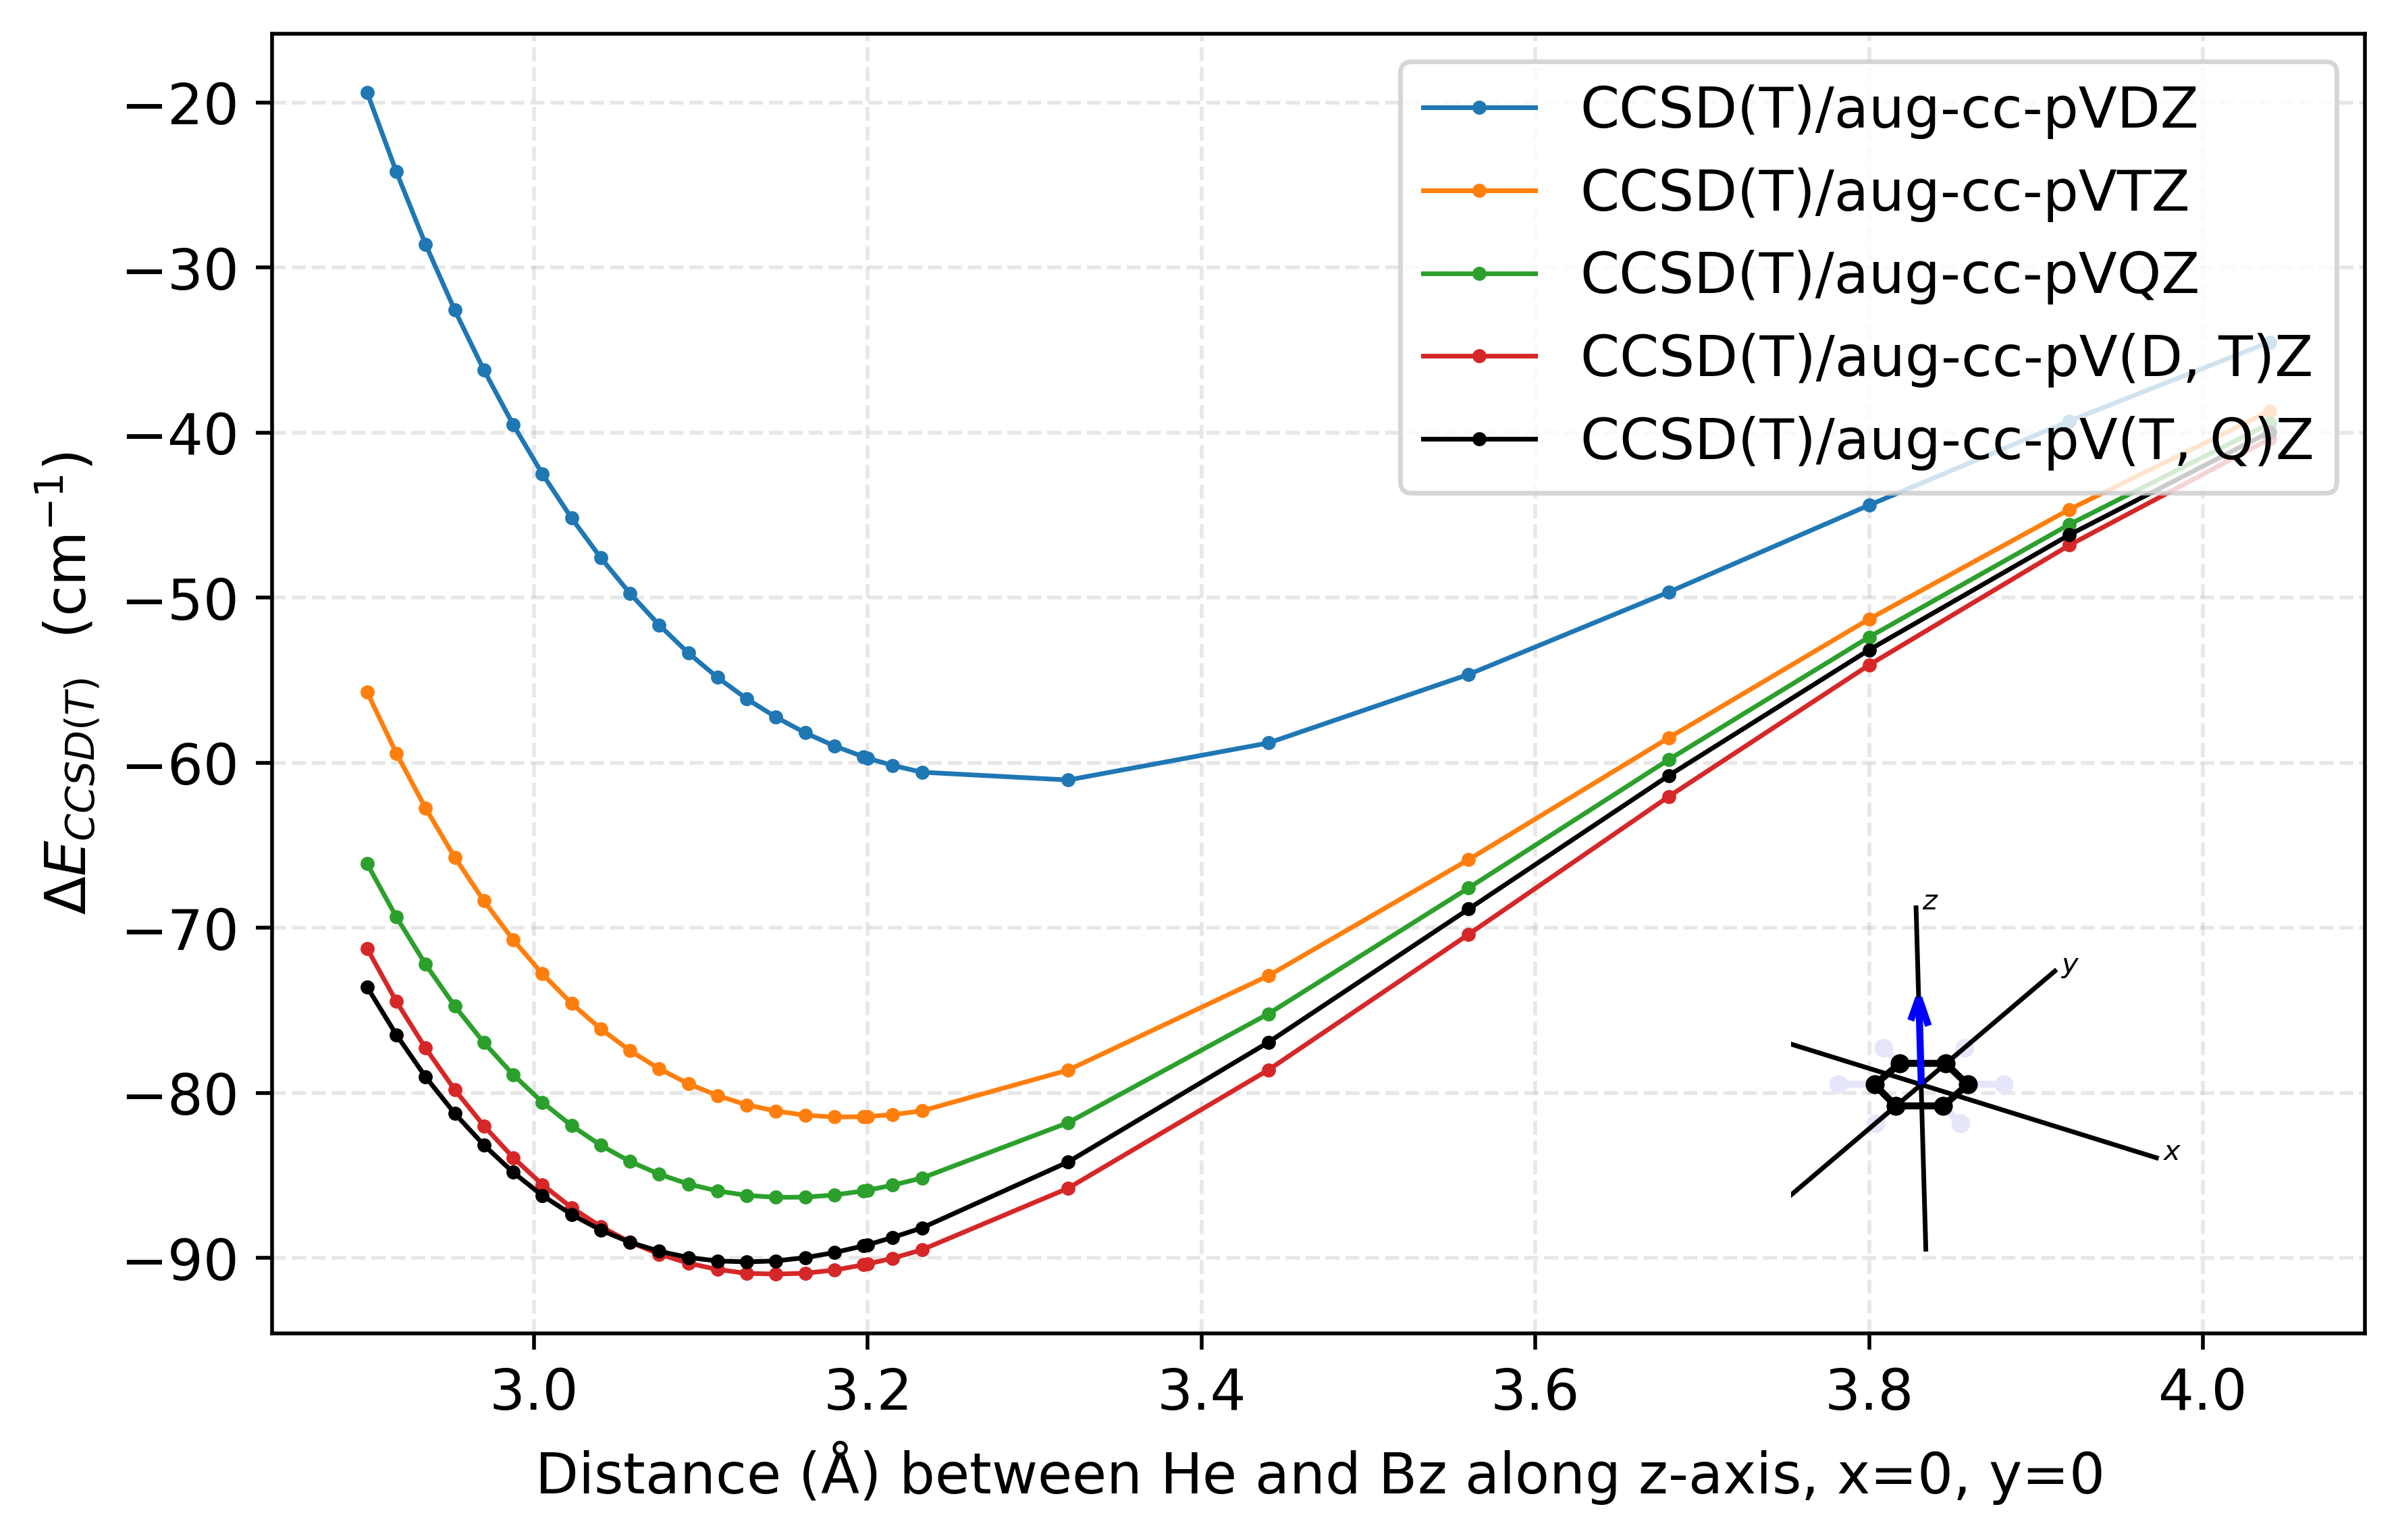

In [10]:
from helplers.he_bz_pes_plot import *
import matplotlib.pyplot as plt


line_width = 0.75

start_pt_cc_plt = 5
end_pt_cc_plt = 33

plot_distances = [float(d[0].split("___")[-1]) for d in sorted_results][
    start_pt_cc_plt:end_pt_cc_plt
]

start_idx = 5
end_idx = 33
data_slice = slice(start_idx, end_idx)


LINE_WIDTH = 0.75


basis_set_curves = [
    {
        "y_data": aug_cc_pVDZ[data_slice],
        "label": "CCSD(T)/aug-cc-pVDZ",
        "linewidth": LINE_WIDTH,
    },
    {
        "y_data": aug_cc_pVTZ[data_slice],
        "label": "CCSD(T)/aug-cc-pVTZ",
        "linewidth": LINE_WIDTH,
    },
    {
        "y_data": aug_cc_pVQZ[data_slice],
        "label": "CCSD(T)/aug-cc-pVQZ",
        "linewidth": LINE_WIDTH,
    },
    {
        "y_data": cbs_dt[data_slice],
        "label": "CCSD(T)/aug-cc-pV(D, T)Z",
        "linewidth": LINE_WIDTH,
    },
    {
        "y_data": cbs_tq[data_slice],
        "label": "CCSD(T)/aug-cc-pV(T, Q)Z",
        "linewidth": LINE_WIDTH * 2,
        "color": "black",
    },
]


set_pub_style()

_, ax = plt.subplots(figsize=(8, 5), dpi=500)


plot_curves_on_axis(
    ax,
    plot_distances,
    basis_set_curves,
    r"Distance ($\mathrm{\AA}$) between He and Bz along z-axis, x=0, y=0",
    r"$\Delta E_{CCSD(T)}$" + f"  ({energy_unit[1]})",
)

quiver_args = (0, 0.01, 0, 0, 0, 8)
inset_position = [0.65, 0.05, 0.4, 0.4]
plot_inset_benzene(ax, inset_position, *quiver_args)

plt.show()